In [18]:
from scipy import io
import os
import numpy as np

data_path = 'C:/Users/allen/OneDrive/Desktop/Work/Scripts/Lidar Simulation/lidarmodeling_202404'

redwood_file = 'rw_alltreeinfo.mat'
guiana_file = 'fg_alltreeinfo.mat'

redwood_filepath = os.path.normpath(os.path.join(data_path, 'RW008', redwood_file))
guiana_filepath = os.path.normpath(os.path.join(data_path, 'FG008', guiana_file))

redwood_mat_data = io.loadmat(redwood_filepath)
guiana_mat_data = io.loadmat(guiana_filepath)

# redwood_list_arrays = []
# redwood_keys  = []
# # Iterate over the items in redwood_mat_data
# for key, value in redwood_mat_data.items():
#     redwood_keys.append(key)
#     print(key)

# tree_data_type = type(redwood_mat_data['tree'])
# print("Data type of redwood_mat_data['tree']:", tree_data_type)

# # Print the shape of the array
# print("Shape of redwood_mat_data['tree']:", redwood_mat_data['tree'].shape)

# Print the data type of the array
# print("Data type of elements in redwood_mat_data['tree']:", redwood_mat_data['tree'].dtype)

# # [3] is 4th tree in array, [1] is stem info, [3] is phi value
# base_value = redwood_mat_data['tree'][0][3][1][0][0][4][0][0]  
# print(base_value)

# Radius of each circle (half of the diameter)
radius = 33.33 / 2

# Leaf Density ratio
redwood_leaf_density_ratio = 2500  # Leaves per m3
guiana_leaf_density_ratio = 8750  # Leaves per m3

# for tree_element in redwood_mat_data['tree'][0]:
#     d1_value = tree_element[0][0][0][1][0][0]
#     d1_values.append(d1_value)

# print(len(d1_values))
# print(type(d1_value))
# print(d1_values)

In [42]:
import math

### Redwood stats

redwood_tree_elements = redwood_mat_data['tree'][0]

# Arrays containing x, y coordinates for each tree
redwood_x_values = redwood_mat_data['tree_x'][0]
redwood_y_values = redwood_mat_data['tree_y'][0]

# Dictionary to store indices of points within each circle
redwood_tree_data = {f'Tree [{i}]': {'crown_base': 0, 
                        'crown_d1': 0, 'crown_d2': 0, 'crown_d3': 0,
                        'crown_center_height': 0, 'tree_height': 0, 
                        'crown_base_height': 0,
                        'crown_volume': 0, 'single_leaf_area': 0, 
                        'total_leaf_area': 0, 'total_tree_branch_area': 0,
                        'total_tree_stem_area': 0, 'total_tree_ground_area': 0, 
                        'total_tree_canopy_veg_area': 0
                        } 
                        for i in range(1, len(redwood_tree_elements) + 1)}

redwood_circle_indices = {f'Circle [{i}, {j}]': {'indices': [], 'crown_vol_in_circle': [], 
                        'crown_percentage': [], 'tree_density': 0, 'tree_percent_total': 0,
                        'mean_crown_d1': 0, 'std_crown_d1': 0, 'mean_crown_d2': 0,
                        'std_crown_d2': 0, 'mean_crown_center_height': 0, 
                        'std_crown_center_height': 0, 'mean_tree_height': 0,
                        'std_tree_height': 0, 
                        'mean_crown_volume': 0, 'std_crown_volume': 0,
                        'total_crown_volume': 0, 'total_vegetation_area_per_pixel': 0,
                        'LAI_per_pixel': 0, 'h1': 0, 'h2': 0, 'Fa': 0,
                        'Fa_b': 0
                        }
                        for i in range(3, 0, -1) for j in range(1, 4)}

def circle_intersection_percentage(x1, y1, r1, x2, y2, r2):
    # Calculate the area of the first circle
    area1 = math.pi * r1**2
    
    # Calculate the distance between the centers of the circles
    d = math.sqrt((x2 - x1)**2 + (y2 - y1)**2)
    
    # Check if the circles are separate or one is completely inside the other
    if d >= r1 + r2:
        # Circles are separate, no intersection
        return 0
    elif d <= abs(r1 - r2) and r1 >= r2:
        # Circle 2 is completely inside circle 1, intersection area is area of circle 2
        return math.pi * r2**2 / area1 * 100
    elif d <= abs(r1 - r2) and r1 < r2:
        # Circle 1 is completely inside circle 2, intersection area is area of circle 1
        return 100
    else:
        # Calculate the intersection area using the formula for the area of a circular segment
        A = r1**2 * math.acos((d**2 + r1**2 - r2**2) / (2 * d * r1)) + r2**2 * math.acos((d**2 + r2**2 - r1**2) / (2 * d * r2)) - 0.5 * math.sqrt((-d + r1 + r2) * (d + r1 - r2) * (d - r1 + r2) * (d + r1 + r2))
        return A / area1 * 100

# Loop through each coordinate in the arrays along with its index
for tree_index, (x, y, tree_element) in enumerate(zip(redwood_x_values, redwood_y_values, redwood_tree_elements), start=1):

    # Extract base, d1, d2, d3 value from tree crown
    base = tree_element[0][0][0][0][0][0]
    d1 = tree_element[0][0][0][1][0][0]
    d2 = tree_element[0][0][0][2][0][0]
    d3 = tree_element[0][0][0][3][0][0]
    
    # Add basic info to each tree
    redwood_tree_data[f'Tree [{tree_index}]']['crown_base'] = base
    redwood_tree_data[f'Tree [{tree_index}]']['crown_d1'] = d1
    redwood_tree_data[f'Tree [{tree_index}]']['crown_d2'] = d2
    redwood_tree_data[f'Tree [{tree_index}]']['crown_d3'] = d3

    # Calculate the volume of the tree spheroid
    crown_volume = (4/3) * math.pi * d2**2 * d1
    
    # Calculate the Crown Center Height for each tree in the circle
    crown_center_height = base + (d3 / 2)

    # Calculate the Crown Base height
    crown_base_height = crown_center_height - d1

    # Calculate the Tree Height for each tree in the circle
    tree_height = base + d1 + (d3 / 2)

    # Calculate total ground area, just the area of circle with crown_radius d1
    total_tree_ground_areas = math.pi * d1**2

    redwood_tree_data[f"Tree [{tree_index}]"]['crown_center_height'] = crown_center_height
    redwood_tree_data[f"Tree [{tree_index}]"]['crown_base_height'] = crown_base_height
    redwood_tree_data[f"Tree [{tree_index}]"]['tree_height'] = tree_height
    redwood_tree_data[f"Tree [{tree_index}]"]['crown_volume'] = crown_volume
    redwood_tree_data[f"Tree [{tree_index}]"]['total_tree_ground_area'] = total_tree_ground_areas

    # Extract leaf number, leaf width, tree leaf, calculate leaf area, then total leaf area
    single_leaf_length = tree_element[5][0][0][1][0][0]
    single_leaf_width = tree_element[5][0][0][2][0][0]
    single_leaf_area = single_leaf_length * 2 * single_leaf_width
    redwood_tree_data[f'Tree [{tree_index}]']['single_leaf_area'] = single_leaf_area

    # Calculate and assign total_leaf_areas
    total_leaf_area = single_leaf_area * redwood_leaf_density_ratio * crown_volume
    redwood_tree_data[f"Tree [{tree_index}]"]['total_leaf_area'] = total_leaf_area

    # Initial values for total primary, secondary, and tertiary branch areas
    total_prim_branch_area = 0
    total_sec_branch_area = 0
    total_tert_branch_area = 0

    # For each tree, iterate through each primary branch array to get the total primary branch area
    for prim_branch_index, branch_element in enumerate(zip(tree_element[2][0][0][0][0])):
        prim_branch_length = tree_element[2][0][0][0][0][prim_branch_index]
        prim_branch_radius = tree_element[2][0][0][1][0][prim_branch_index]
        prim_branch_area = 2 * prim_branch_radius * prim_branch_length
        total_prim_branch_area = total_prim_branch_area + prim_branch_area

    # for each tree, iterate through each secondary branch array to get the total secondary branch area
    for sec_branch_index, branch_element in enumerate(zip(tree_element[3][0][0][0][0])):
        sec_branch_length = tree_element[3][0][0][0][0][sec_branch_index]
        sec_branch_radius = tree_element[3][0][0][1][0][sec_branch_index]
        sec_branch_area = 2 * sec_branch_radius * sec_branch_length
        total_sec_branch_area = total_sec_branch_area + sec_branch_area    
    
    # for each tree, iterate through each tertiary branch array to get the total tertiary branch area
    for tert_branch_index, branch_element in enumerate(zip(tree_element[4][0][0][0][0])):
        tert_branch_length = tree_element[4][0][0][0][0][tert_branch_index]
        tert_branch_radius = tree_element[4][0][0][1][0][tert_branch_index]
        tert_branch_area = 2 * tert_branch_radius * tert_branch_length
        total_tert_branch_area = total_tert_branch_area + tert_branch_area

    total_branch_area = total_prim_branch_area + total_sec_branch_area + total_tert_branch_area
    redwood_tree_data[f'Tree [{tree_index}]']['total_tree_branch_area'] = total_branch_area

    tree_total_canopy_veg_areas = total_leaf_area + total_branch_area
    redwood_tree_data[f"Tree [{tree_index}]"]['total_tree_canopy_veg_area'] = tree_total_canopy_veg_areas

    # Flag to indicate whether the point falls within a circle
    circle_within_grid = False

    # Check each circle in the 3x3 grid
    for i in range(3, 0, -1):
        for j in range(1, 4):
            # Calculate the center of the current circle
            center_x = (j-2) * 2 * radius
            center_y = (i-2) * 2 * radius
            
            # Calculate distance from the center of the current circle
            dist = math.sqrt((center_x - x)**2 + (center_y - y)**2)
            
            # Check if the distance is less than or equal to the radius
            if dist <= radius + d2:
                print(f'Tree {tree_index} at {x}, {y} found in: [{i}, {j}]')

                # Calculate the volume of the intersection between the tree and the circle
                intersection_percentage = circle_intersection_percentage(x, y, d2, center_x, center_y, radius) / 100
                intersection_volume = crown_volume * intersection_percentage
                print(f'\tTree {tree_index} crown volume is: {crown_volume}')
                print(f'\tTree {tree_index} intersection percentage with Circle [{i}, {j}] is: {intersection_percentage}')
                print(f'\tApprox. Tree {tree_index} intersection volume with Circle [{i}, {j}] is: {intersection_volume}\n')

                # Add the tree values to the corresponding circle's list
                circle_name = f'Circle [{i}, {j}]'
                circle_data = redwood_circle_indices[circle_name]
                circle_data['indices'].append(tree_index)

                # Add intersection volume to the 'crown_vol_in_circle' field
                redwood_circle_indices[circle_name]['crown_percentage'].append(intersection_percentage)
                redwood_circle_indices[circle_name]['crown_vol_in_circle'].append(intersection_volume)

                circle_within_grid = True  # Set flag to True

    # If the tree is not found within any circle, print the message
    if not circle_within_grid:
        print(f'Tree {tree_index} at {x}, {y} with radius {d2} not found within any grid circle!\n')

for tree_index, (x, y, tree_element) in enumerate(zip(redwood_x_values, redwood_y_values, redwood_tree_elements), start=1):
#     print(f'\tTree {tree_index} crown_base value: {tree_data[f'Tree [{tree_index}]']['crown_base']}')
#     print(f'\tTree {tree_index} crown_d1 value: {tree_data[f'Tree [{tree_index}]']['crown_d1']}')
#     print(f'\tTree {tree_index} crown_d2 value: {tree_data[f'Tree [{tree_index}]']['crown_d2']}')
#     print(f'\tTree {tree_index} crown_d3 value: {tree_data[f'Tree [{tree_index}]']['crown_d3']}')
    print(f'\tTree {tree_index} crown center height: {redwood_tree_data[f'Tree [{tree_index}]']['crown_center_height']}')

Tree 1 at -58.22, 39.89 with radius 2.70483 not found within any grid circle!

Tree 2 at -58.43, 32.12 with radius 3.09267 not found within any grid circle!

Tree 3 at -62.59, 25.39 with radius 3.60917 not found within any grid circle!

Tree 4 at -66.96, 7.555 with radius 4.76444 not found within any grid circle!

Tree 5 at -35.2, 60.06 with radius 3.14531 not found within any grid circle!

Tree 6 at -49.26, 45.81 with radius 2.53781 not found within any grid circle!

Tree 7 at -50.29, 35.88 found in: [3, 1]
	Tree 7 crown volume is: 628.8833706166984
	Tree 7 intersection percentage with Circle [3, 1] is: 0.40186714818073294
	Approx. Tree 7 intersection volume with Circle [3, 1] is: 252.72756668801952

Tree 8 at -51.46, 13.73 with radius 3.5683 not found within any grid circle!

Tree 9 at -61.64, 15.29 with radius 3.66206 not found within any grid circle!

Tree 10 at -51.77, 5.978 found in: [2, 1]
	Tree 10 crown volume is: 1664.3174364922547
	Tree 10 intersection percentage with Circle 

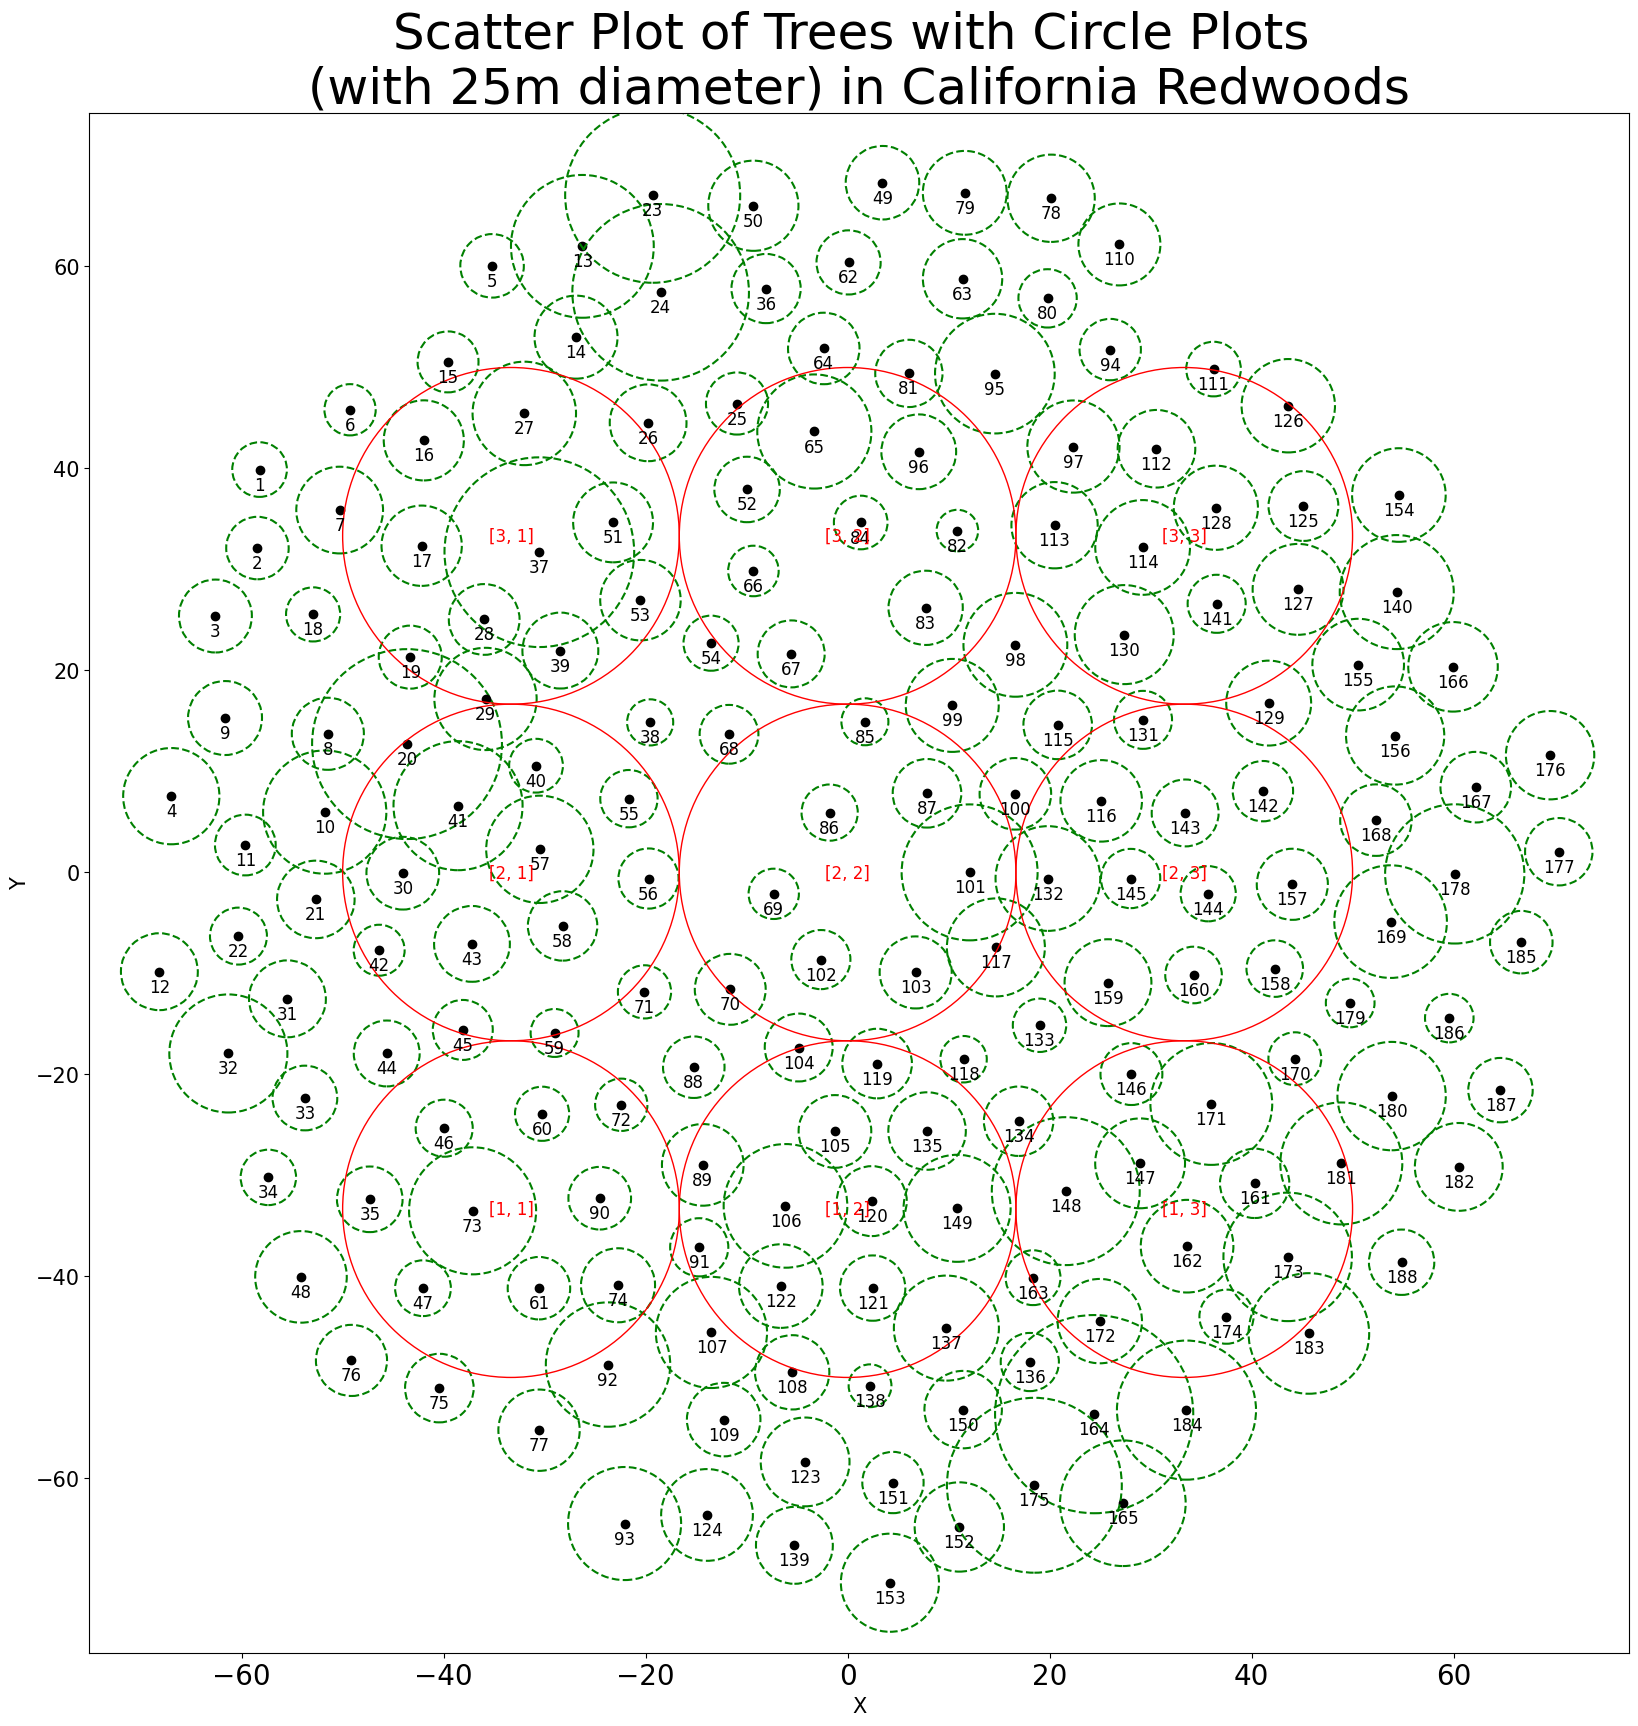

In [32]:
import matplotlib.pyplot as plt

# Set the figure size
plt.figure(figsize=(20, 20))

plt.rcParams['axes.titlesize'] = 36
plt.rcParams['axes.labelsize'] = 15
plt.rcParams['xtick.labelsize'] = 20
plt.rcParams['ytick.labelsize'] = 15

# Create a scatter plot for each tree
for index, (x, y, tree_element) in enumerate(zip(redwood_x_values, redwood_y_values, redwood_tree_elements), start=1):
    # Extract d1 value from tree crown
    d1 = tree_element[0][0][0][1][0][0]
    d2 = tree_element[0][0][0][2][0][0]
    plt.scatter(x, y, color='black', marker='o')  # Black dot for tree
    
    # Draw green circle around the tree with radius equal to d1
    circle = plt.Circle((x, y), d2, color='green', fill=False, linestyle='--', linewidth=1.5)
    plt.gca().add_artist(circle)

    # Add text label for the tree index slightly below the point
    plt.text(x, y - 1.5, str(index), ha='center', va='center', fontsize=12)  # Adjust fontsize and offset as needed

# Plot the circles and label them
for i in range(3, 0, -1):
    for j in range(1, 4):
        center_x = (j - 2)  * 2 * radius
        center_y = (i - 2)  * 2 * radius
        circle = plt.Circle((center_x, center_y), radius, color='red', fill=False)
        plt.gca().add_artist(circle)
        plt.text(center_x, center_y, f'[{i}, {j}]', ha='center', va='center', fontsize=12, color='red')  # Adjust fontsize as needed

# Add labels, title, etc. if required
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Scatter Plot of Trees with Circle Plots \n(with 25m diameter) in California Redwoods')

# Set equal aspect ratio
plt.gca().set_aspect('equal', adjustable='box')

plt.savefig('RW008_trees_plots.png')

# Show the plot
plt.show()

In [49]:
tree_sum = 0

print("California Redwood Results:\n")

# for tree_index, (x, y, tree_element) in enumerate(zip(x_values, y_values, tree_elements), start=1):
#     print(f'\tTree {tree_index} crown_base value: {tree_data[f'Tree [{tree_index}]']['crown_base']}')
#     print(f'\tTree {tree_index} crown_d1 value: {tree_data[f'Tree [{tree_index}]']['crown_d1']}')
#     print(f'\tTree {tree_index} crown_d2 value: {tree_data[f'Tree [{tree_index}]']['crown_d2']}')
#     print(f'\tTree {tree_index} crown_d3 value: {tree_data[f'Tree [{tree_index}]']['crown_d3']}')

for circle_name, data in redwood_circle_indices.items():
    # Extract indices for the current circle
    tree_indices = data['indices']

    # print (tree_indices)
    # for tree_index in tree_indices:
    #     try:
    #         print(f"Tree [{tree_index}] crown_base value: {tree_data[f'Tree [{tree_index}]']['crown_base']}")
    #     except KeyError:
    #         print(f"Tree [{tree_index}] does not have a 'crown_base' value.")

    # Initialize lists to store values for the current circle
    base_values = [redwood_tree_data[f'Tree [{tree_index}]']['crown_base'] for tree_index in tree_indices]
    d1_values = [redwood_tree_data[f'Tree [{tree_index}]']['crown_d1'] for tree_index in tree_indices]
    d2_values = [redwood_tree_data[f'Tree [{tree_index}]']['crown_d2'] for tree_index in tree_indices]
    d3_values = [redwood_tree_data[f'Tree [{tree_index}]']['crown_d3'] for tree_index in tree_indices]
    single_leaf_areas = [redwood_tree_data[f'Tree [{tree_index}]']['single_leaf_area'] for tree_index in tree_indices]
    tree_branch_areas = [redwood_tree_data[f'Tree [{tree_index}]']['total_tree_branch_area'] for tree_index in tree_indices]
    crown_volumes = [redwood_tree_data[f'Tree [{tree_index}]']['crown_volume'] for tree_index in tree_indices]
    crown_center_height = [redwood_tree_data[f'Tree [{tree_index}]']['crown_center_height'] for tree_index in tree_indices]
    tree_height = [redwood_tree_data[f'Tree [{tree_index}]']['tree_height'] for tree_index in tree_indices]
    crown_volumes_in_circle = data['crown_vol_in_circle']
    crown_percentages = data['crown_percentage']
    total_leaf_areas = [redwood_tree_data[f"Tree [{tree_index}]"]['total_leaf_area'] for tree_index in tree_indices]
    total_tree_canopy_veg_area = [redwood_tree_data[f"Tree [{tree_index}]"]['total_tree_canopy_veg_area'] for tree_index in tree_indices]
    
    # Calculate number of trees found in the circle
    tree_percent_total = np.sum(crown_percentages)
    num_trees = tree_percent_total
    # Calculate area of the circle
    pixel_area = math.pi * (radius ** 2)
    # Calculate tree density
    tree_density = num_trees / pixel_area

    tree_sum = tree_sum + num_trees

    # Calculate leaf, branch and total canopy vegetation areas, added adjusted areas with partial crown percentages
    adj_leaf_areas = [single_leaf_area * redwood_leaf_density_ratio * adj_crown_volumes for single_leaf_area, adj_crown_volumes in zip(single_leaf_areas, crown_volumes_in_circle)]
    adj_branch_areas = [branch_area * crown_percentage for branch_area, crown_percentage in zip(tree_branch_areas, crown_percentages)]
    total_adj_tree_canopy_veg_area = [adj_leaf_area + adj_branch_area for adj_leaf_area, adj_branch_area in zip(adj_leaf_areas, adj_branch_areas)]

    # Calculate mean and standard deviation of 'd1' values
    mean_d1 = np.mean(d1_values)
    std_d1 = np.std(d1_values)
    mean_d2 = np.mean(d2_values)
    std_d2 = np.std(d2_values)
    mean_crown_center_height = np.mean(crown_center_height)
    std_crown_center_height = np.std(crown_center_height)
    mean_tree_height = np.mean(tree_height)
    std_tree_height = np.std(tree_height)
    mean_crown_volume = np.mean(crown_volumes_in_circle)
    std_crown_volume = np.std(crown_volumes_in_circle)
    total_crown_volume = np.sum(crown_volumes)
    total_pixel_veg_area = np.sum(total_adj_tree_canopy_veg_area)
    total_leaf_veg_area = np.sum(adj_leaf_areas)
    adj_total_crown_volume = np.sum(crown_volumes_in_circle)

    # Calculate h1 and h2 each circle
    h1 = mean_crown_center_height - (2 * std_crown_center_height)
    h2 = mean_crown_center_height + (2 * std_crown_center_height)

    LAI_index = total_pixel_veg_area/pixel_area
    LAI_without_branch = total_leaf_veg_area/pixel_area
    Fa_with_branch = LAI_index/(adj_total_crown_volume / pixel_area)
    Fa_without_branch = LAI_without_branch/(adj_total_crown_volume / pixel_area)

    # Update circle_indices with calculated values
    redwood_circle_indices[circle_name]['tree_density'] = (tree_density)
    redwood_circle_indices[circle_name]['mean_crown_d1'] = (mean_d1)
    redwood_circle_indices[circle_name]['std_crown_d1'] = (std_d1)
    redwood_circle_indices[circle_name]['mean_crown_d2'] = (mean_d2)
    redwood_circle_indices[circle_name]['std_crown_d2'] = (std_d2)
    redwood_circle_indices[circle_name]['mean_crown_center_height'] = (mean_crown_center_height)
    redwood_circle_indices[circle_name]['std_crown_center_height'] = (std_crown_center_height)
    redwood_circle_indices[circle_name]['mean_tree_height'] = (mean_tree_height)
    redwood_circle_indices[circle_name]['std_tree_height'] = (std_tree_height)
    redwood_circle_indices[circle_name]['mean_crown_volume'] = (mean_crown_volume)
    redwood_circle_indices[circle_name]['std_crown_volume'] = (std_crown_volume)
    redwood_circle_indices[circle_name]['total_crown_volume'] = (adj_total_crown_volume)
    redwood_circle_indices[circle_name]['total_vegetation_area_per_pixel'] = (total_pixel_veg_area)
    redwood_circle_indices[circle_name]['LAI_per_pixel'] = (LAI_without_branch)
    redwood_circle_indices[circle_name]['h1'] = (h1)
    redwood_circle_indices[circle_name]['h2'] = (h2)
    redwood_circle_indices[circle_name]['Fa'] = (Fa_without_branch)
    redwood_circle_indices[circle_name]['Fa_b'] = (Fa_with_branch)


    # Print results
    print(f"Total Trees found in {circle_name}: {tree_percent_total}")
    print(f"\tPercentage of Trees found in {circle_name}: {crown_percentages}")
    print(f"\tTree Density: {tree_density}\n")
    print(f"\tMean Vertical Crown Radius: {mean_d1}, STD Vertical Crown Radius: {std_d1}")
    print(f"\tMean Horizontal Crown Radius: {mean_d2}, STD Horizontal Crown Radius: {std_d2}")
    print(f"\tMean Crown Center Height: {mean_crown_center_height}, STD Crown Center Height: {std_crown_center_height}\n")
    print(f"\tTree Heights: {tree_height}")
    print(f"\tMean Tree Height: {mean_tree_height}, STD Tree Height: {std_tree_height}\n") 
    print(f"\tCrown Volume found in Circle: {circle_name}: {crown_volumes_in_circle}")
    print(f"\tMean Crown Volume: {mean_crown_volume}, STD Crown Volume: {std_crown_volume}")
    print(f"\tTotal Crown Volume: {total_crown_volume}")
    print(f"\tAdjusted Partial Crown Volumes: {adj_total_crown_volume}\n")
    print(f"\th1: {h1}, h2: {h2}\n")
    print(f"\tTree Single Leaf Areas: {single_leaf_area}")
    print(f"\tTree Total Leaf Areas: {adj_leaf_areas}") 
    print(f"\tTree Branch Areas: {adj_branch_areas}\n") 
    print(f"\tTotal Vegetation Areas per tree: {total_tree_canopy_veg_area}") 
    print(f"\tTotal Vegetation Areas per Pixel: {total_pixel_veg_area}") 
    print(f"\tTotal Vegetation Areas per Pixel without branch areas: {total_leaf_veg_area}\n") 
    print(f"\tCircle Pixel area: {pixel_area}\n") 
    print(f"\tLAI Index per Unit Area: {LAI_index}")
    print(f"\tLAI Index per Unit Area without branch areas: {LAI_without_branch}\n")
    print(f"\tFa per Unit Area: {Fa_with_branch}")
    print(f"\tFa per Unit Area without branch areas: {Fa_without_branch}\n")

for circle_name, data in redwood_circle_indices.items():
    # Extract indices for the current circle
    tree_indices = data['indices']

    crown_percentages = data['crown_percentage']
    tree_percent_total = np.sum(crown_percentages)

    print(f"Total Trees found in {circle_name}: {tree_percent_total}")

    # Print tree indices for each circle
    print(f"Tree indices: {tree_indices}")
    print("Percent of tree crown in circle: " + ", ".join([f"{percentage:.4f}" for percentage in crown_percentages]))

print(f"\nTotal number of trees found in all circles: {tree_sum} out of {len(redwood_tree_elements)}")

California Redwood Results:

Total Trees found in Circle [3, 1]: 9.977835595864548
	Percentage of Trees found in Circle [3, 1]: [0.40186714818073294, 0.0013762051549870765, 0.16001347000789015, 0.9973410071179784, 1.0, 0.6938513038511629, 0.08528799046907447, 0.32437587086922176, 0.9687295578606551, 1.0, 0.5075709554584787, 1.0, 1.0, 1.0, 0.8374220868943664]
	Tree Density: 0.011436044460900527

	Mean Vertical Crown Radius: 8.339922666666665, STD Vertical Crown Radius: 2.046458352007085
	Mean Horizontal Crown Radius: 4.697061333333334, STD Horizontal Crown Radius: 1.9237231649412436
	Mean Crown Center Height: 18.156868666666664, STD Crown Center Height: 4.632891239967926

	Tree Heights: [25.94412, 26.03559, 19.149729999999998, 23.71524, 23.94105, 19.64225, 41.678149999999995, 23.85574, 29.039830000000002, 20.77117, 29.2986, 42.180749999999996, 23.126829999999998, 25.44789, 23.62493]
	Mean Tree Height: 26.496791333333327, STD Tree Height: 6.6682868443660155

	Crown Volume found in Circle

In [44]:
import re

# Define the file path where you want to save the data
tree_file_path = "redwood_output/tree_data.txt"

with open(tree_file_path, 'w') as file:
    for tree_index, tree_values in redwood_tree_data.items():
        # Write tree index to file
        file.write(f"{tree_index}:\n")

        # Write tree values to file
        for field, value in tree_values.items():
            if isinstance(value, list):
                # If the value is a list, format it as a bullet list
                formatted_value = "    - ".join(map(lambda x: f"{x:.5f}" if isinstance(x, float) else str(x), value))
                file.write(f"  {field}:    - {formatted_value}\n")
            elif isinstance(value, float):
                # If the value is a float, format it with 5 significant digits
                formatted_value = f"{value:.5f}"
                file.write(f"  {field}: {formatted_value}\n")
            else:
                # If the value is not a list or float, write it as is
                file.write(f"  {field}: {value}\n")

        # Add a newline for better readability
        file.write("\n")

def strip_and_replace(input_string):
    # Define the pattern to match brackets, spaces, and commas
    pattern = r'[\[\],\s]'
    # Replace the matched characters with underscores
    replaced_string = re.sub(pattern, '_', input_string)
    # Replace consecutive underscores with a single underscore
    replaced_string = re.sub(r'_+', '_', replaced_string)
    return replaced_string

circle_path_prefix = "redwood_output/"

for circle_name, data in redwood_circle_indices.items():

    gort_input_fn = strip_and_replace(circle_name)

    file_path = f"{circle_path_prefix}{gort_input_fn}.in"

    with open(file_path, "w") as file:
        file.write("1\n")
        file.write(f'\t{data['tree_density']}')
        file.write(f'\t{data['Fa']}')
        file.write(f'\t{data['h1']}')
        file.write(f'\t{data['h2']}')
        file.write(f'\t0.1')
        file.write(f'\t{data['mean_crown_d2']}')
        file.write(f'\t{data['mean_crown_d1']}')
        file.write(f'\t0.00')
        file.write(f'\t0.4291')
        file.write(f'\t0.4239')
        file.write(f'\t0.35156')
        file.write(f'\t1')

    file_path = f"{circle_path_prefix}{gort_input_fn}branch.in"

    with open(file_path, "w") as file:
        file.write("1\n")
        file.write(f'\t{data['tree_density']}')
        file.write(f'\t{data['Fa_b']}')
        file.write(f'\t{data['h1']}')
        file.write(f'\t{data['h2']}')
        file.write(f'\t0.1')
        file.write(f'\t{data['mean_crown_d2']}')
        file.write(f'\t{data['mean_crown_d1']}')
        file.write(f'\t0.00')
        file.write(f'\t0.4291')
        file.write(f'\t0.4239')
        file.write(f'\t0.35156')
        file.write(f'\t1')

    file_path = f"{circle_path_prefix}circle_data_{circle_name}.txt"
    with open(file_path, 'w') as file:
        # Write the circle data to the file
        file.write(f"{circle_name}:\n")
        for field, value in data.items():
            # Check if the value is a list
            if isinstance(value, list):
                # Write the field and list of values to the file
                file.write(f"  {field}:\n")
                for item in value:
                    file.write(f"    - {item}\n")
            else:
                # Write the field and single value to the file
                file.write(f"  {field}: {value}\n")

In [23]:
import math

### Guiana stats

guiana_tree_elements = guiana_mat_data['tree'][0]

# Arrays containing x, y coordinates for each tree
guiana_x_values = guiana_mat_data['tree_x'][0]
guiana_y_values = guiana_mat_data['tree_y'][0]

# Dictionary to store indices of points within each circle
guiana_tree_data = {f'Tree [{i}]': {'crown_base': 0, 
                        'crown_d1': 0, 'crown_d2': 0, 'crown_d3': 0,
                        'crown_center_height': [], 'tree_height': [], 
                        'crown_base_height': [],
                        'crown_volume': [], 'single_leaf_areas': [], 
                        'total_leaf_areas': [], 'total_tree_branch_area': 0,
                        'total_tree_stem_areas': [], 'total_tree_ground_areas': [], 
                        'total_tree_canopy_veg_areas': []
                        } 
                        for i in range(1, len(guiana_tree_elements) + 1)}

guiana_circle_indices = {f'Circle [{i}, {j}]': {'indices': [], 'crown_vol_in_circle': [], 
                        'radius': radius, 'crown_percentage': [], 'tree_density': 0,
                        'mean_crown_d1': 0, 'std_crown_d1': 0, 'mean_crown_d2': 0,
                        'std_crown_d2': 0, 'mean_crown_center_height': 0, 
                        'std_crown_center_height': 0, 'mean_tree_height': 0,
                        'std_tree_height': 0,
                        'mean_crown_volume': 0, 'std_crown_volume': 0,
                        'total_crown_volume': 0, 'total_vegetation_area_per_pixel': 0,
                        'LAI_per_pixel': 0, 'h1': 0, 'h2': 0, 'Fa': 0
                        }
                        for i in range(3, 0, -1) for j in range(1, 4)}

def circle_intersection_percentage(x1, y1, r1, x2, y2, r2):
    # Calculate the area of the first circle
    area1 = math.pi * r1**2
    
    # Calculate the distance between the centers of the circles
    d = math.sqrt((x2 - x1)**2 + (y2 - y1)**2)
    
    # Check if the circles are separate or one is completely inside the other
    if d >= r1 + r2:
        # Circles are separate, no intersection
        return 0
    elif d <= abs(r1 - r2) and r1 >= r2:
        # Circle 2 is completely inside circle 1, intersection area is area of circle 2
        return math.pi * r2**2 / area1 * 100
    elif d <= abs(r1 - r2) and r1 < r2:
        # Circle 1 is completely inside circle 2, intersection area is area of circle 1
        return 100
    else:
        # Calculate the intersection area using the formula for the area of a circular segment
        A = r1**2 * math.acos((d**2 + r1**2 - r2**2) / (2 * d * r1)) + r2**2 * math.acos((d**2 + r2**2 - r1**2) / (2 * d * r2)) - 0.5 * math.sqrt((-d + r1 + r2) * (d + r1 - r2) * (d - r1 + r2) * (d + r1 + r2))
        return A / area1 * 100

# Loop through each coordinate in the arrays along with its index
for tree_index, (x, y, tree_element) in enumerate(zip(guiana_x_values, guiana_y_values, guiana_tree_elements), start=1):

    # Extract base, d1, d2, d3 value from tree crown
    base = tree_element[0][0][0][0][0][0]
    d1 = tree_element[0][0][0][1][0][0]
    d2 = tree_element[0][0][0][2][0][0]
    d3 = tree_element[0][0][0][3][0][0]

    # Extract leaf number, leaf width, tree leaf, calculate leaf area, then total leaf area
    single_leaf_length = tree_element[5][0][0][1][0][0]
    single_leaf_width = tree_element[5][0][0][2][0][0]
    single_leaf_area = single_leaf_length * 2 * single_leaf_width

    # Initial values for total primary, secondary, and tertiary branch areas
    total_prim_branch_area = 0
    total_sec_branch_area = 0
    total_tert_branch_area = 0

    # For each tree, iterate through each primary branch array to get the total primary branch area
    for prim_branch_index, branch_element in enumerate(zip(tree_element[2][0][0][0][0])):
        prim_branch_length = tree_element[2][0][0][0][0][prim_branch_index]
        prim_branch_radius = tree_element[2][0][0][1][0][prim_branch_index]
        prim_branch_area = 2 * prim_branch_radius * prim_branch_length
        total_prim_branch_area = total_prim_branch_area + prim_branch_area

    # for each tree, iterate through each secondary branch array to get the total secondary branch area
    for sec_branch_index, branch_element in enumerate(zip(tree_element[3][0][0][0][0])):
        sec_branch_length = tree_element[3][0][0][0][0][sec_branch_index]
        sec_branch_radius = tree_element[3][0][0][1][0][sec_branch_index]
        sec_branch_area = 2 * sec_branch_radius * sec_branch_length
        total_sec_branch_area = total_sec_branch_area + sec_branch_area    
    
    # for each tree, iterate through each tertiary branch array to get the total tertiary branch area
    for tert_branch_index, branch_element in enumerate(zip(tree_element[4][0][0][0][0])):
        tert_branch_length = tree_element[4][0][0][0][0][tert_branch_index]
        tert_branch_radius = tree_element[4][0][0][1][0][tert_branch_index]
        tert_branch_area = 2 * tert_branch_radius * tert_branch_length
        total_tert_branch_area = total_tert_branch_area + tert_branch_area

    total_branch_area = total_prim_branch_area + total_sec_branch_area + total_tert_branch_area

    # Add basic info to each tree
    guiana_tree_data[f'Tree [{tree_index}]']['crown_base'] = (base)
    guiana_tree_data[f'Tree [{tree_index}]']['crown_d1'] = (d1)
    guiana_tree_data[f'Tree [{tree_index}]']['crown_d2'] = (d2)
    guiana_tree_data[f'Tree [{tree_index}]']['crown_d3'] = (d3)
    guiana_tree_data[f'Tree [{tree_index}]']['single_leaf_areas'].append(single_leaf_area)
    guiana_tree_data[f'Tree [{tree_index}]']['total_tree_branch_area'] = (total_branch_area)

    # Calculate the Crown Center Height for each tree in the circle
    crown_center_height = base + (d3 / 2)
    
    # Calculate the Crown Base height
    crown_base_height = crown_center_height - d1

    # Calculate the Tree Height for each tree in the circle
    tree_height = base + d1 + (d3 / 2)

    # Calculate the Crown Volume for each tree in the circle
    crown_volumes = (4/3) * math.pi * d2**2 * d1

    # Calculate total ground area, just the area of circle with crown_radius d1
    total_tree_ground_areas = math.pi * d1**2

    guiana_tree_data[f"Tree [{tree_index}]"]['crown_center_height'] = crown_center_height
    guiana_tree_data[f"Tree [{tree_index}]"]['crown_base_height'] = crown_base_height
    guiana_tree_data[f"Tree [{tree_index}]"]['tree_height'] = tree_height
    guiana_tree_data[f"Tree [{tree_index}]"]['crown_volume'] = crown_volumes
    guiana_tree_data[f"Tree [{tree_index}]"]['total_tree_ground_areas'] = total_tree_ground_areas

    # Flag to indicate whether the point falls within a circle
    circle_within_grid = False

    # Check each circle in the 3x3 grid
    for i in range(3, 0, -1):
        for j in range(1, 4):
            # Calculate the center of the current circle
            center_x = (j-2) * 2 * radius
            center_y = (i-2) * 2 * radius
            
            # Calculate distance from the center of the current circle
            dist = math.sqrt((center_x - x)**2 + (center_y - y)**2)
            
            # Check if the distance is less than or equal to the radius
            if dist <= radius + d2:
                print(f'Tree {tree_index} at {x}, {y} found in: [{i}, {j}]')

                # Calculate the volume of the intersection between the tree and the circle
                intersection_percentage = circle_intersection_percentage(x, y, d2, center_x, center_y, radius) / 100
                intersection_volume = crown_volumes * intersection_percentage
                print(f'\tTree {tree_index} crown volume is: {crown_volumes}')
                print(f'\tTree {tree_index} intersection percentage with Circle [{i}, {j}] is: {intersection_percentage}')
                print(f'\tApprox. Tree {tree_index} intersection volume with Circle [{i}, {j}] is: {intersection_volume}\n')

                # Add the tree values to the corresponding circle's list
                circle_name = f'Circle [{i}, {j}]'
                circle_data = guiana_circle_indices[circle_name]
                circle_data['indices'].append(tree_index)

                # Add intersection volume to the 'crown_vol_in_circle' field
                guiana_circle_indices[circle_name]['crown_percentage'].append(intersection_percentage)
                guiana_circle_indices[circle_name]['crown_vol_in_circle'].append(intersection_volume)

                circle_within_grid = True  # Set flag to True

    # If the tree is not found within any circle, print the message
    if not circle_within_grid:
        print(f'Tree {tree_index} at {x}, {y} with radius {d2} not found within any grid circle!\n')

# for tree_index, (x, y, tree_element) in enumerate(zip(x_values, y_values, tree_elements), start=1):
#     print(f'\tTree {tree_index} crown_base value: {tree_data[f'Tree [{tree_index}]']['crown_base']}')
#     print(f'\tTree {tree_index} crown_d1 value: {tree_data[f'Tree [{tree_index}]']['crown_d1']}')
#     print(f'\tTree {tree_index} crown_d2 value: {tree_data[f'Tree [{tree_index}]']['crown_d2']}')
#     print(f'\tTree {tree_index} crown_d3 value: {tree_data[f'Tree [{tree_index}]']['crown_d3']}')

Tree 1 at 55.95, -20.39 with radius 1.41868 not found within any grid circle!

Tree 2 at -51.72, 33.54 with radius 1.16317 not found within any grid circle!

Tree 3 at -62.09, 13.0 with radius 1.3905 not found within any grid circle!

Tree 4 at 33.89, -55.33 with radius 2.17272 not found within any grid circle!

Tree 5 at 53.8, -33.69 with radius 1.33417 not found within any grid circle!

Tree 6 at -53.52, -4.385 with radius 2.37698 not found within any grid circle!

Tree 7 at -53.43, -12.93 with radius 2.38285 not found within any grid circle!

Tree 8 at -41.57, 26.13 found in: [3, 1]
	Tree 8 crown volume is: 34.63258029135336
	Tree 8 intersection percentage with Circle [3, 1] is: 1.0
	Approx. Tree 8 intersection volume with Circle [3, 1] is: 34.63258029135336

Tree 9 at -64.31, 28.41 with radius 3.06327 not found within any grid circle!

Tree 10 at -58.1, 2.741 with radius 1.73891 not found within any grid circle!

Tree 11 at -27.89, 63.75 with radius 0.827106 not found within any gr

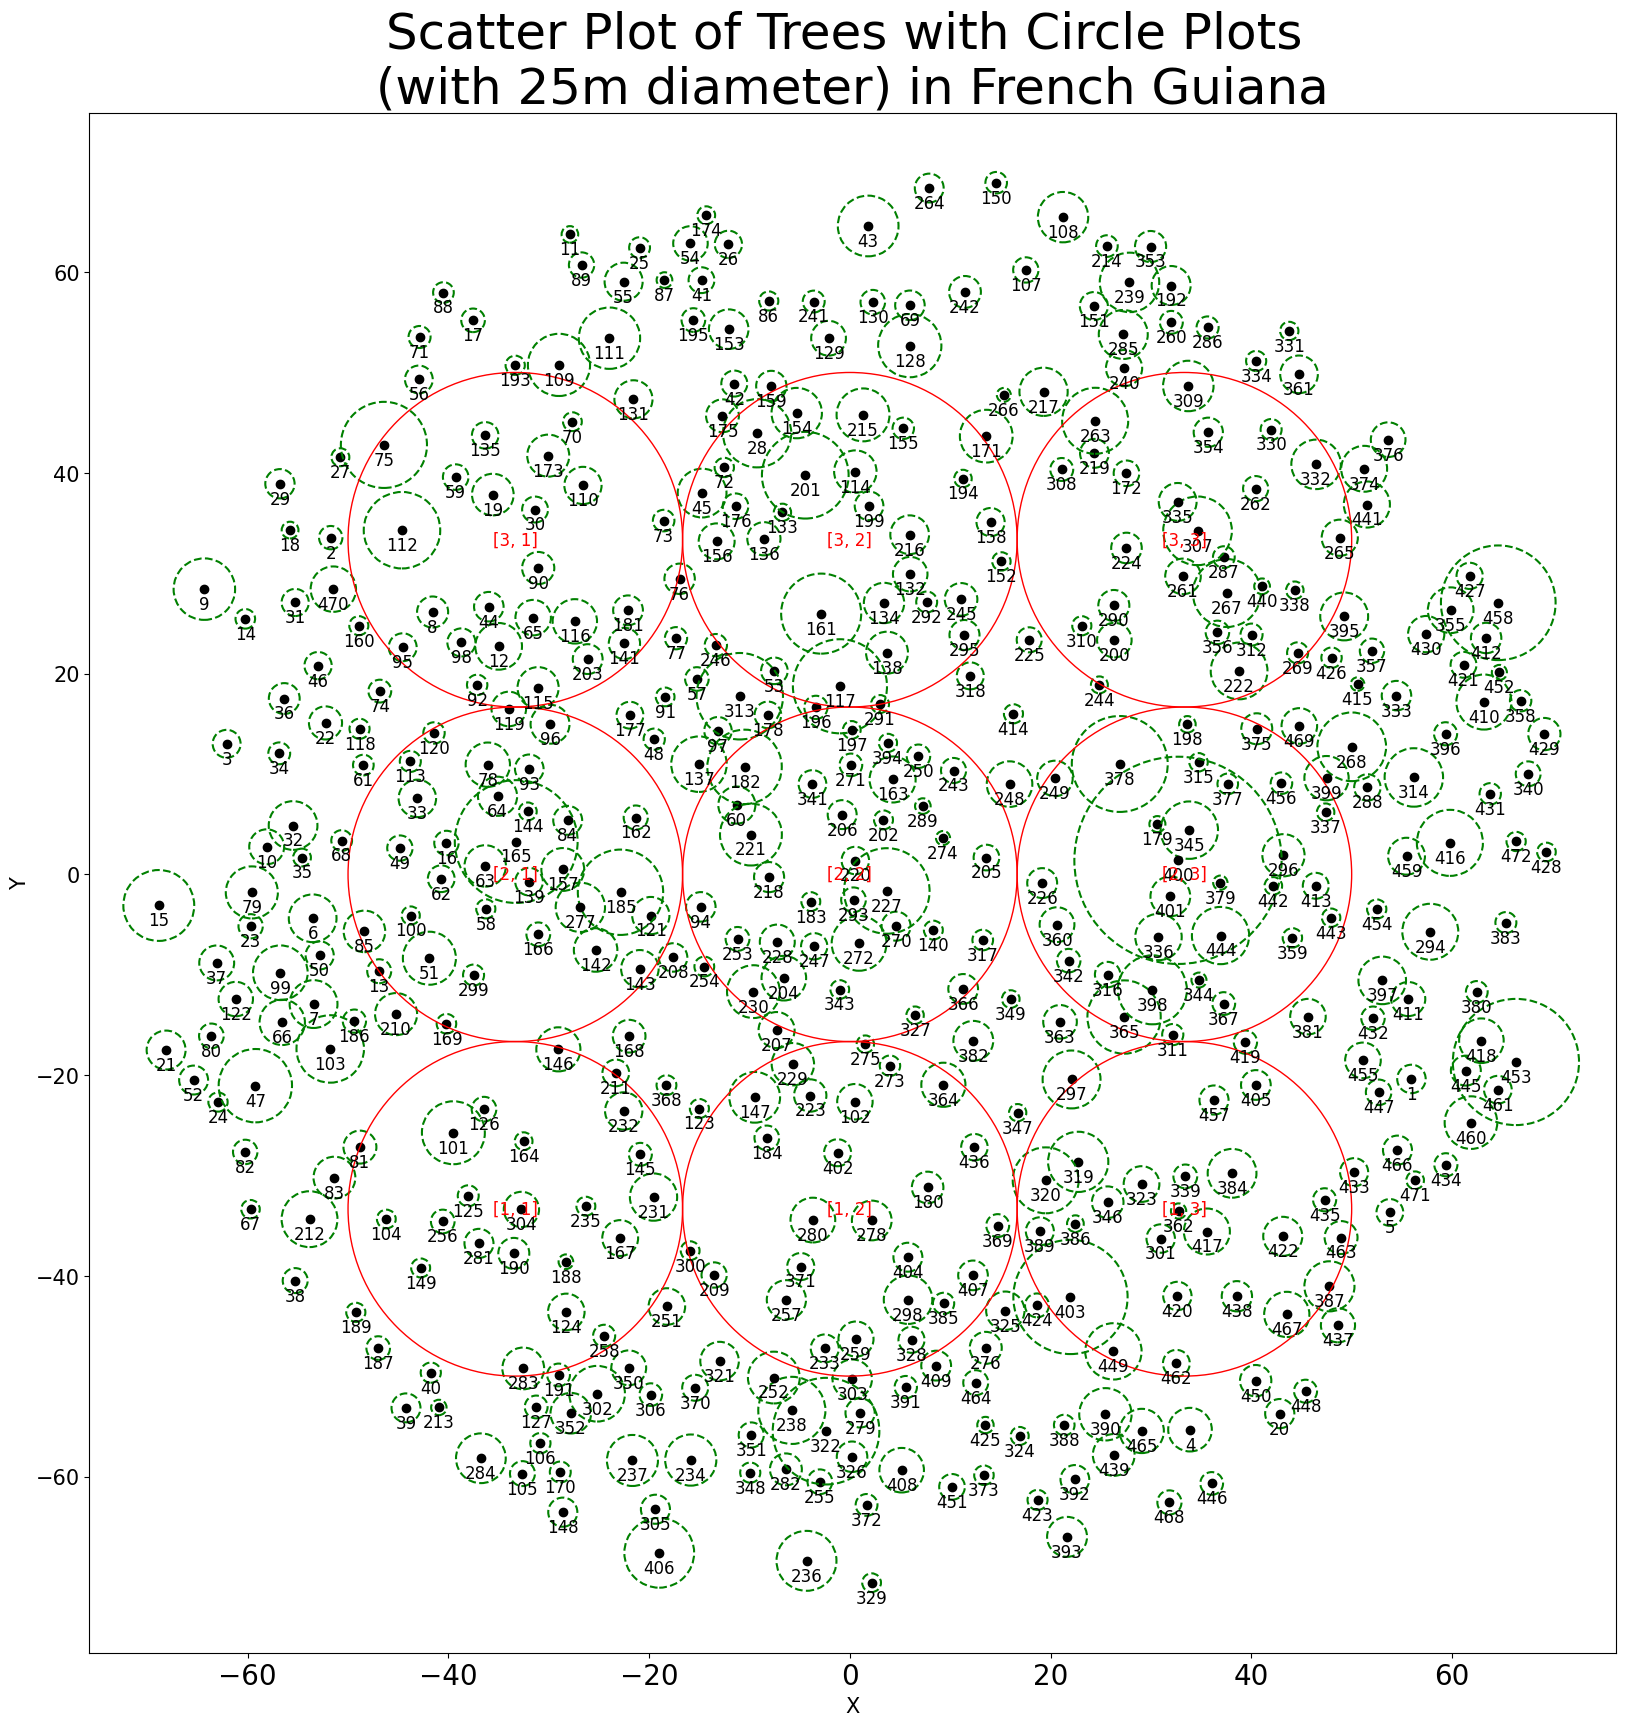

In [29]:
import matplotlib.pyplot as plt

# Set the figure size
plt.figure(figsize=(20, 20))

plt.rcParams['axes.titlesize'] = 36
plt.rcParams['axes.labelsize'] = 15
plt.rcParams['xtick.labelsize'] = 20
plt.rcParams['ytick.labelsize'] = 15

# Create a scatter plot for each tree
for index, (x, y, tree_element) in enumerate(zip(guiana_x_values, guiana_y_values, guiana_tree_elements), start=1):
    # Extract d1 value from tree crown
    d1 = tree_element[0][0][0][1][0][0]
    d2 = tree_element[0][0][0][2][0][0]
    plt.scatter(x, y, color='black', marker='o')  # Black dot for tree
    
    # Draw green circle around the tree with radius equal to d1
    circle = plt.Circle((x, y), d2, color='green', fill=False, linestyle='--', linewidth=1.5)
    plt.gca().add_artist(circle)

    # Add text label for the tree index slightly below the point
    plt.text(x, y - 1.5, str(index), ha='center', va='center', fontsize=12)  # Adjust fontsize and offset as needed

# Plot the circles and label them
for i in range(3, 0, -1):
    for j in range(1, 4):
        center_x = (j - 2) * 2 * radius
        center_y = (i - 2) * 2 * radius
        circle = plt.Circle((center_x, center_y), radius, color='red', fill=False)
        plt.gca().add_artist(circle)
        plt.text(center_x, center_y, f'[{i}, {j}]', ha='center', va='center', fontsize=12, color='red')  # Adjust fontsize as needed

# Add labels, title, etc. if required
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Scatter Plot of Trees with Circle Plots \n(with 25m diameter) in French Guiana')

# Set equal aspect ratio
plt.gca().set_aspect('equal', adjustable='box')

plt.savefig('FG_008_trees_plots.png')

# Show the plot
plt.show()

In [26]:
tree_sum = 0

print("French Guiana Results:\n")

# for tree_index, (x, y, tree_element) in enumerate(zip(x_values, y_values, tree_elements), start=1):
#     print(f'\tTree {tree_index} crown_base value: {tree_data[f'Tree [{tree_index}]']['crown_base']}')
#     print(f'\tTree {tree_index} crown_d1 value: {tree_data[f'Tree [{tree_index}]']['crown_d1']}')
#     print(f'\tTree {tree_index} crown_d2 value: {tree_data[f'Tree [{tree_index}]']['crown_d2']}')
#     print(f'\tTree {tree_index} crown_d3 value: {tree_data[f'Tree [{tree_index}]']['crown_d3']}')

for circle_name, data in guiana_circle_indices.items():
    # Extract indices for the current circle
    tree_indices = data['indices']

    # print (tree_indices)
    # for tree_index in tree_indices:
    #     try:
    #         print(f"Tree [{tree_index}] crown_base value: {tree_data[f'Tree [{tree_index}]']['crown_base']}")
    #     except KeyError:
    #         print(f"Tree [{tree_index}] does not have a 'crown_base' value.")

    # Initialize lists to store values for the current circle
    base_values = [guiana_tree_data[f'Tree [{tree_index}]']['crown_base'] for tree_index in tree_indices]
    d1_values = [guiana_tree_data[f'Tree [{tree_index}]']['crown_d1'] for tree_index in tree_indices]
    d2_values = [guiana_tree_data[f'Tree [{tree_index}]']['crown_d2'] for tree_index in tree_indices]
    d3_values = [guiana_tree_data[f'Tree [{tree_index}]']['crown_d3'] for tree_index in tree_indices]
    single_leaf_areas = [guiana_tree_data[f'Tree [{tree_index}]']['single_leaf_areas'][0] for tree_index in tree_indices]
    tree_branch_areas = [guiana_tree_data[f'Tree [{tree_index}]']['total_tree_branch_area'] for tree_index in tree_indices]
    crown_volumes = [guiana_tree_data[f'Tree [{tree_index}]']['crown_volume'] for tree_index in tree_indices]
    crown_center_height = [guiana_tree_data[f'Tree [{tree_index}]']['crown_center_height'] for tree_index in tree_indices]
    tree_height = [guiana_tree_data[f'Tree [{tree_index}]']['tree_height'] for tree_index in tree_indices]
    crown_volumes_in_circle = data['crown_vol_in_circle']
    crown_percentages = data['crown_percentage']
    
    # Calculate number of trees found in the circle
    tree_percent_total = np.sum(crown_percentages)
    num_trees = tree_percent_total
    # Calculate area of the circle
    pixel_area = math.pi * (radius ** 2)
    # Calculate tree density
    tree_density = num_trees / pixel_area

    tree_sum = tree_sum + num_trees

    # Calculate leaf, branch and total canopy vegetation areas, added adjusted areas with partial crown percentages
    total_leaf_areas = [single_leaf * guiana_leaf_density_ratio * crown_volume for single_leaf, crown_volume in zip(single_leaf_areas, crown_volumes)]
    adj_leaf_areas = [single_leaf * guiana_leaf_density_ratio * adj_crown_volumes for single_leaf, adj_crown_volumes in zip(single_leaf_areas, crown_volumes_in_circle)]
    adj_branch_areas = [branch_area * crown_percentage for branch_area, crown_percentage in zip(tree_branch_areas, crown_percentages)]
    tree_total_canopy_veg_areas = [leaf + branch for leaf, branch in zip(adj_leaf_areas, adj_branch_areas)]

    # Calculate mean and standard deviation of 'd1' values
    mean_d1 = np.mean(d1_values)
    std_d1 = np.std(d1_values)
    mean_d2 = np.mean(d2_values)
    std_d2 = np.std(d2_values)
    mean_crown_center_height = np.mean(crown_center_height)
    std_crown_center_height = np.std(crown_center_height)
    mean_tree_height = np.mean(tree_height)
    std_tree_height = np.std(tree_height)
    mean_crown_volume = np.mean(crown_volumes)
    std_crown_volume = np.std(crown_volumes)
    total_crown_volume = np.sum(crown_volumes)
    total_pixel_veg_area = np.sum(tree_total_canopy_veg_areas)
    total_leaf_veg_area = np.sum(adj_leaf_areas)
    adj_total_crown_volume = np.sum(crown_volumes_in_circle)

    # Calculate h1 and h2 each circle
    h1 = mean_crown_center_height - (2 * std_crown_center_height)
    h2 = mean_crown_center_height + (2 * std_crown_center_height)

    LAI_index = total_pixel_veg_area/pixel_area
    LAI_without_branch = total_leaf_veg_area/pixel_area
    Fa_with_branch = LAI_index/(adj_total_crown_volume / pixel_area)
    Fa_without_branch = LAI_without_branch/(adj_total_crown_volume / pixel_area)

    single_leaf = single_leaf_areas[0]

    New_Fa_value = single_leaf * guiana_leaf_density_ratio

    processed_indices = set()

    # Update tree_data with calculated values
    for i, tree_index in enumerate(tree_indices, start=1):
        # Populate tree_data for the current tree index
        guiana_tree_data[f"Tree [{tree_index}]"]['total_leaf_areas'] = total_leaf_areas[i - 1]
        guiana_tree_data[f"Tree [{tree_index}]"]['total_tree_canopy_veg_areas'] = tree_total_canopy_veg_areas[i - 1]

    # Update circle_indices with calculated values
    guiana_circle_indices[circle_name]['tree_density'] = (tree_density)
    guiana_circle_indices[circle_name]['mean_crown_d1'] = (mean_d1)
    guiana_circle_indices[circle_name]['std_crown_d1'] = (std_d1)
    guiana_circle_indices[circle_name]['mean_crown_d2'] = (mean_d2)
    guiana_circle_indices[circle_name]['std_crown_d2'] = (std_d2)
    guiana_circle_indices[circle_name]['mean_crown_center_height'] = (mean_crown_center_height)
    guiana_circle_indices[circle_name]['std_crown_center_height'] = (std_crown_center_height)
    guiana_circle_indices[circle_name]['mean_tree_height'] = (mean_tree_height)
    guiana_circle_indices[circle_name]['std_tree_height'] = (std_tree_height)
    guiana_circle_indices[circle_name]['mean_crown_volume'] = (mean_crown_volume)
    guiana_circle_indices[circle_name]['std_crown_volume'] = (std_crown_volume)
    guiana_circle_indices[circle_name]['total_crown_volume'] = (total_crown_volume)
    guiana_circle_indices[circle_name]['total_vegetation_area_per_pixel'] = (total_pixel_veg_area)
    guiana_circle_indices[circle_name]['LAI_per_pixel'] = (LAI_without_branch)
    guiana_circle_indices[circle_name]['h1'] = (h1)
    guiana_circle_indices[circle_name]['h2'] = (h2)
    guiana_circle_indices[circle_name]['Fa'] = (Fa_without_branch)


    # Print results
    print(f"Total Trees found in {circle_name}: {tree_percent_total}")
    print(f"Mean Vertical Crown Radius: {mean_d1}, STD Vertical Crown Radius: {std_d1}")
    print(f"Mean Horizontal Crown Radius: {mean_d2}, STD Horizontal Crown Radius: {std_d2}")
    print(f"Mean Crown Center Height: {mean_crown_center_height}, STD Crown Center Height: {std_crown_center_height}")
    print(f"Tree Heights: {tree_height}")
    print(f"Mean Tree Height: {mean_tree_height}, STD Tree Height: {std_tree_height}") 
    print(f"Crown Volume found in Circle: {circle_name}: {crown_volumes_in_circle}")
    print(f"Mean Crown Volume: {mean_crown_volume}, STD Crown Volume: {std_crown_volume}")
    print(f"Total Crown Volume: {total_crown_volume}")
    print(f"Adjusted Partial Crown Volumes: {adj_total_crown_volume}")
    print(f"h1: {h1}, h2: {h2}")
    print(f"Tree Single Leaf Areas: {single_leaf_areas}")
    print(f"Tree Total Leaf Areas: {adj_leaf_areas}") 
    print(f"Tree Branch Areas: {adj_branch_areas}") 
    print(f"Total Vegetation Areas per tree: {tree_total_canopy_veg_areas}") 
    print(f"Total Vegetation Areas per Pixel: {total_pixel_veg_area}") 
    print(f"Total Vegetation Areas per Pixel without branch areas: {total_leaf_veg_area}") 
    print(f"Circle Pixel area: {pixel_area}") 
    print(f"LAI Index per Pixel: {LAI_index}")
    print(f"LAI Index per Pixel without branch areas: {LAI_without_branch}")
    print(f"Fa per Pixel: {Fa_with_branch}")
    print(f"Fa per Pixel without branch areas: {Fa_without_branch}")
    print(f"New Fa (leaf area * number of leaves per m3): {New_Fa_value}")
    print(f"Tree Density: {tree_density}")
    print()

for circle_name, data in guiana_circle_indices.items():
    # Extract indices for the current circle
    tree_indices = data['indices']

    crown_percentages = data['crown_percentage']
    tree_percent_total = np.sum(crown_percentages)

    print(f"Total Trees found in {circle_name}: {tree_percent_total}")

    # Print tree indices for each circle
    print(f"Tree indices: {tree_indices}")
    print("Percent of tree crown in circle: " + ", ".join([f"{percentage:.4f}" for percentage in crown_percentages]))

print(f"\nTotal number of trees found in all circles: {tree_sum} out of {len(guiana_tree_elements)}")

French Guiana Results:

Total Trees found in Circle [3, 1]: 23.649871049516214
Mean Vertical Crown Radius: 3.6343355172413796, STD Vertical Crown Radius: 0.8213381284875865
Mean Horizontal Crown Radius: 1.8198377931034484, STD Horizontal Crown Radius: 0.7668498326318808
Mean Crown Center Height: 15.248786379310344, STD Crown Center Height: 3.583493453055921
Tree Heights: [17.76094, 22.519305, 21.749280000000002, 15.298335, 17.242845, 15.80978, 19.746605, 10.50497, 13.365590000000001, 29.933690000000002, 16.906480000000002, 18.665264999999998, 12.65155, 16.277459999999998, 17.006045, 26.037664999999997, 19.91271, 28.27196, 21.130225, 22.274164999999996, 19.598855, 20.279335000000003, 15.473889999999999, 18.31535, 21.33794, 17.72251, 12.08245, 17.673195, 22.062145]
Mean Tree Height: 18.88312189655172, STD Tree Height: 4.397591805144394
Crown Volume found in Circle: Circle [3, 1]: [34.63258029135336, 95.81066403606438, 75.23592130080719, 20.662246947733312, 30.225639775870825, 21.38387799

In [27]:
import re

# Define the file path where you want to save the data
tree_file_path = "guiana_output/tree_data.txt"

with open(tree_file_path, 'w') as file:
    for tree_index, tree_values in guiana_tree_data.items():
        # Write tree index to file
        file.write(f"{tree_index}:\n")

        # Write tree values to file
        for field, value in tree_values.items():
            if isinstance(value, list):
                # If the value is a list, format it as a bullet list
                formatted_value = "    - ".join(map(lambda x: f"{x:.5f}" if isinstance(x, float) else str(x), value))
                file.write(f"  {field}:    - {formatted_value}\n")
            elif isinstance(value, float):
                # If the value is a float, format it with 5 significant digits
                formatted_value = f"{value:.5f}"
                file.write(f"  {field}: {formatted_value}\n")
            else:
                # If the value is not a list or float, write it as is
                file.write(f"  {field}: {value}\n")

        # Add a newline for better readability
        file.write("\n")

circle_path_prefix = "guiana_output/"

def strip_and_replace(input_string):
    # Define the pattern to match brackets, spaces, and commas
    pattern = r'[\[\],\s]'
    # Replace the matched characters with underscores
    replaced_string = re.sub(pattern, '_', input_string)
    # Replace consecutive underscores with a single underscore
    replaced_string = re.sub(r'_+', '_', replaced_string)
    return replaced_string

for circle_name, data in guiana_circle_indices.items():

    gort_input_fn = strip_and_replace(circle_name)
    file_path = f"{circle_path_prefix}{gort_input_fn}.in"

    with open(file_path, "w") as file:
        file.write("1\n")
        file.write(f'\t{data['tree_density']}')
        file.write(f'\t{data['Fa']}')
        file.write(f'\t{data['h1']}')
        file.write(f'\t{data['h2']}')
        file.write(f'\t0.1')
        file.write(f'\t{data['mean_crown_d2']}')
        file.write(f'\t{data['mean_crown_d1']}')
        file.write(f'\t0.00')
        file.write(f'\t0.4291')
        file.write(f'\t0.4239')
        file.write(f'\t0.35156')
        file.write(f'\t1')

    file_path = f"{circle_path_prefix}circle_data_{circle_name}.txt"
    with open(file_path, 'w') as file:
        # Write the circle data to the file
        file.write(f"{circle_name}:\n")
        for field, value in data.items():
            # Check if the value is a list
            if isinstance(value, list):
                # Write the field and list of values to the file
                file.write(f"  {field}:\n")
                for item in value:
                    file.write(f"    - {item}\n")
            else:
                # Write the field and single value to the file
                file.write(f"  {field}: {value}\n")